In [1]:
import sys
import os
import torch
import yaml
import jsonlines
#import logger

from easydict import EasyDict as edict
from pytorch_transformers.tokenization_bert import BertTokenizer
#from vilbert.datasets import ConceptCapLoaderTrain, ConceptCapLoaderVal
from vilbert.vilbert import VILBertForVLTasks, BertConfig, BertForMultiModalPreTraining, BertLayerNorm , GeLU
#from vilbert.task_utils import LoadDatasetEval

import numpy as np
import matplotlib.pyplot as plt
import PIL
import _pickle as cPickle
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict
from PIL import Image
import cv2
import argparse
import glob
from types import SimpleNamespace
import pdb


from tensorboardX import SummaryWriter
writter = SummaryWriter()


In [2]:
from typing import Any, Dict, List
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import _pickle as cPickle

from pytorch_transformers.tokenization_bert import BertTokenizer

import jsonlines
import sys
import pdb
import torch.nn as nn

# ViLBERT for Image classification class

## 0.1 Utils

In [4]:
class VILBertForImageClassification(torch.nn.Module):

    def __init__(self,config_file, num_labels, from_pretrained, default_gpu=True):
        """ Vilbert Model adapted to perform image classification. The output of the visual 

        """
        super(VILBertForImageClassification,self).__init__()
        # Bert configuration
        self.config = BertConfig.from_json_file(config_file)
        #ViLBERT model
        self.vilbertBase = VILBertForVLTasks.from_pretrained(
            from_pretrained,
            config=self.config,
            num_labels=num_labels,
            default_gpu=default_gpu,
        )

        # Last fully connected layer (design taken from original paper)
        self.ImageClassifFC = nn.Sequential(
            nn.Linear(self.config.bi_hidden_size, self.config.bi_hidden_size * 2),
            GeLU(),
            BertLayerNorm(self.config.bi_hidden_size * 2 , eps=1e-12),
            nn.Linear(self.config.bi_hidden_size * 2 , num_labels),
        )


    def forward(
        self,
        input_txt,
        input_imgs,
        image_loc,
        token_type_ids=None,
        attention_mask=None,
        image_attention_mask=None,
        co_attention_mask=None,
        task_ids=None,
        output_all_encoded_layers=False,
        output_all_attention_masks=False,
    ):

        # Forward pass through the 
        vil_prediction, vil_prediction_gqa, vil_logit, vil_binary_prediction, vil_tri_prediction, vision_prediction, vision_logit, linguisic_prediction, linguisic_logit, all_attention_mask, sequence_output_v, pooled_output_v = self.vilbertBase(
            input_txt, input_imgs, image_loc, token_type_ids, attention_mask, image_attention_mask, co_attention_mask, task_ids, output_all_encoded_layers, output_all_attention_masks,
        )

        # get image logits (use visual pooled output which is an overall represerntation of the image features)
        imageLogits = self.ImageClassifFC(pooled_output_v)

    

        return (
            imageLogits,
            vil_prediction,
            vil_prediction_gqa,
            vil_logit,
            vil_binary_prediction,
            vil_tri_prediction,
            vision_prediction,
            vision_logit,
            linguisic_prediction,
            linguisic_logit,
            all_attention_mask,
            sequence_output_v, ## added by Alejandro Hernandez Díaz
            pooled_output_v
        )

In [5]:
# Demo Arguments
args = SimpleNamespace(from_pretrained= "save/pretrained_model.bin",
                       bert_model="bert-base-uncased",
                       config_file="config/bert_base_6layer_6conect.json",
                       max_seq_length=101,
                       train_batch_size=1,
                       do_lower_case=True,
                       predict_feature=False,
                       seed=42,
                       num_workers=0,
                       baseline=False,
                       img_weight=1,
                       distributed=False,
                       objective=1,
                       visual_target=0,
                       dynamic_attention=False,
                       task_specific_tokens=True,
                       tasks='1',
                       save_name='',
                       in_memory=False,
                       batch_size=1,
                       local_rank=-1,
                       split='mteval',
                       clean_train_sets=True
                      )
num_labels = 350
default_gpu=True
config = BertConfig.from_json_file(args.config_file)
#model = VILBertForVLTasks.from_pretrained(
#            args.from_pretrained,
 #           config=config,
 #           num_labels=num_labels,
#            default_gpu=default_gpu,
#        )

newmodel = VILBertForImageClassification(args.config_file,350,args.from_pretrained)

In [33]:
from vilbert.datasets._image_features_reader import ImageFeaturesH5Reader

Ireader = ImageFeaturesH5Reader("data/prueba.lmdb")
features, num_boxes, boxes, _ = Ireader["Places365_val_00000003"]

print((features.shape))


(101, 2048)


In [12]:
import json
annotations_path = "/mnt/c/Users/aleja/Desktop/MSc Project/Implementation/Models/Dataset_Utilities/train.json"
file = open(annotations_path)
with open(annotations_path) as reader:
    for annotation in json.load(reader):
        print(annotation)
        break

{'id': 1, 'img_name': '-user-HS400-ah02299-Desktop-lxmert-totest-Places365_val_00000002', 'img_path': '-user-HS400-ah02299-Desktop-lxmert-totest-Places365_val_00000002.jpg', 'label': 358}


# DATASET CLASS 


### 0.1 Imports

In [52]:
from typing import Any, Dict, List
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import _pickle as cPickle

from pytorch_transformers.tokenization_bert import BertTokenizer

import jsonlines
import sys
import pdb
from pytorch_transformers.tokenization_bert import BertTokenizer

### 0.2 Utils

In [123]:
#### UTILS ###
def _create_entry(item): # 
    entry = {
        "id": item["id"],
        "img_path": item["img_path"],
        "label": item["label"],
        "db_id": item["db_id"],
        "text_input": item["text_input"],
        "input_mask": item["input_mask"],
        "segment_ids": item["segment_ids"]
    }
    return entry

def _load_dataset(annotations_path): ## 
    """Load entries

    dataroot: root path of dataset
    name: 'train', 'val', 'test'
    annotations_pathI: path to the jsonline file for the dataset
    """
    with jsonlines.open(annotations_path) as reader:

        items = []
        count = 0
        for annotation in reader:
            dictionary = {}
            dictionary["id"] = int(annotation["id"])
            dictionary["img_path"] = str(annotation["img_path"])
            dictionary["label"] = int(annotation["label"])
            # "[CLS] [SEP]" == [101, 102] when encoded by bert tokenizer
            dictionary["text_input"] = [101,102]

            ### FIND OUT REAL NAME OF FILES FOR SERVER ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            dictionary["db_id"] = str(annotation["img_path"].split(".")[0])

            dictionary["input_mask"] = [1] * len(dictionary["text_input"])
            dictionary["segment_ids"] = [0] * len(dictionary["text_input"])
            items.append(dictionary)
            count += 1
            
    entries = []
    for item in items:
        entries.append(_create_entry(item))
    return entries

 

### 1. Dataset class

In [131]:
class Places365(Dataset):
    def __init__(
        self,
        annotations_jsonpath: str,
        image_features_reader: ImageFeaturesH5Reader,
        max_region_num: int = 37
    ):
        super().__init__()
        self._max_region_num = max_region_num
        self.num_labels = 365
        self._image_features_reader = image_features_reader
        self.entries = _load_dataset(annotations_jsonpath)


    def __getitem__(self, index):
        entry = self.entries[index]
        db_id = entry["db_id"]
        features, num_boxes, boxes, _ = self._image_features_reader[db_id]
        
        mix_num_boxes = min(int(num_boxes), self._max_region_num)
        mix_boxes_pad = np.zeros((self._max_region_num, 5))
        mix_features_pad = np.zeros((self._max_region_num, 2048))

        image_mask = [1] * (int(mix_num_boxes))
        while len(image_mask) < self._max_region_num:
            image_mask.append(0)

        mix_boxes_pad[:mix_num_boxes] = boxes[:mix_num_boxes]
        mix_features_pad[:mix_num_boxes] = features[:mix_num_boxes]

        features = torch.tensor(mix_features_pad).float()
        image_mask = torch.tensor(image_mask).long()
        spatials = torch.tensor(mix_boxes_pad).float()
        textInput = torch.tensor(entry["text_input"])


        co_attention_mask = torch.zeros((self._max_region_num, 30))
        target = torch.zeros(self.num_labels)

        labels = entry["label"]
        if labels is not None:
            target.scatter_(0, torch.tensor(labels), 1)

        input_mask = torch.from_numpy(np.array(entry["input_mask"]))
        segment_ids = torch.from_numpy(np.array(entry["segment_ids"]))
        return (
            textInput,
            features,
            spatials,
            segment_ids,
            input_mask,
            image_mask,
            co_attention_mask,
            #question_id,
            target,
        )

    def __len__(self):
        return len(self.entries)

### 1.1 DataLoader

#########################################################


NameError: name 'imagefeature' is not defined

In [6]:
from vilbert.datasets.ImageClassificationDataset import get_data_loader as dl
dataloader = dl("data/val.jsonline","data/prueba.lmdb/")
textInput, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, target,= next(iter(dataloader))


#print(model)

In [8]:
newmodel.eval()
imagelogits, no, _, _, _, _, _, _, _, _, _, _, _, = newmodel(textInput, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask)


print(imagelogits)


torch.Size([16, 350])


In [11]:
from vilbert.vilbertImageClassification import VILBertForImageClassification

model = VILBertForImageClassification(args.config_file, 350,args.from_pretrained)

07/07/2022 14:54:55 - INFO - vilbert.utils -   loading weights file save/pretrained_model.bin
07/07/2022 14:55:04 - INFO - vilbert.utils -   Weights of VILBertForVLTasks not initialized from pretrained model: ['vil_prediction.logit_fc.0.weight', 'vil_prediction.logit_fc.0.bias', 'vil_prediction.logit_fc.2.weight', 'vil_prediction.logit_fc.2.bias', 'vil_prediction.logit_fc.3.weight', 'vil_prediction.logit_fc.3.bias', 'vil_prediction_gqa.logit_fc.0.weight', 'vil_prediction_gqa.logit_fc.0.bias', 'vil_prediction_gqa.logit_fc.2.weight', 'vil_prediction_gqa.logit_fc.2.bias', 'vil_prediction_gqa.logit_fc.3.weight', 'vil_prediction_gqa.logit_fc.3.bias', 'vil_binary_prediction.logit_fc.0.weight', 'vil_binary_prediction.logit_fc.0.bias', 'vil_binary_prediction.logit_fc.2.weight', 'vil_binary_prediction.logit_fc.2.bias', 'vil_binary_prediction.logit_fc.3.weight', 'vil_binary_prediction.logit_fc.3.bias', 'vil_logit.weight', 'vil_logit.bias', 'vil_tri_prediction.weight', 'vil_tri_prediction.bias', 

In [1]:
import torch
import torch.distributed as dist
import torch.nn as nn


import numpy as np
import random 


import argparse

from vilbert.vilbert import BertConfig
from vilbert.vilbertImageClassification import VILBertForImageClassification

from pytorch_transformers.optimization import (
    AdamW
)

from torch.optim.lr_scheduler import (
    LambdaLR
)
from torch.nn import CrossEntropyLoss

import json


In [3]:
bert_weight_name = json.load(
        open("config/bert-base-uncased_weight_name.json", "r")
    )
    #config = BertConfig.from_json_file(args.config_file)

model = VILBertForImageClassification("config/bert_base_6layer_6conect.json", 350, "bert-base-uncased")
#model = nn.DataParallel(model)
#torch.cuda.set_device(device)
#model.cuda(device)

#criterion = CrossEntropyLoss()

In [10]:
#for param in model.named_modules():
#print(model.vilbertBase.requires_grad_(False))
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

ImageClassifFC.0.weight tensor([[ 0.0030, -0.0289, -0.0169,  ...,  0.0226, -0.0163,  0.0220],
        [-0.0202, -0.0239, -0.0243,  ..., -0.0305,  0.0045,  0.0158],
        [ 0.0086,  0.0094,  0.0218,  ..., -0.0134, -0.0232, -0.0041],
        ...,
        [-0.0138, -0.0085,  0.0085,  ..., -0.0230,  0.0280, -0.0004],
        [ 0.0045,  0.0264,  0.0193,  ...,  0.0221,  0.0223,  0.0104],
        [ 0.0038, -0.0163,  0.0232,  ...,  0.0009, -0.0035, -0.0078]])
ImageClassifFC.0.bias tensor([-0.0064,  0.0047, -0.0117,  ..., -0.0152,  0.0005, -0.0189])
ImageClassifFC.2.weight tensor([1., 1., 1.,  ..., 1., 1., 1.])
ImageClassifFC.2.bias tensor([0., 0., 0.,  ..., 0., 0., 0.])
ImageClassifFC.3.weight tensor([[-0.0013, -0.0036, -0.0080,  ..., -0.0012,  0.0156, -0.0160],
        [-0.0012,  0.0095, -0.0097,  ..., -0.0109, -0.0102, -0.0109],
        [ 0.0125, -0.0198,  0.0139,  ...,  0.0031,  0.0178, -0.0206],
        ...,
        [ 0.0157, -0.0095,  0.0171,  ...,  0.0063,  0.0200,  0.0081],
        [-

In [12]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

print(output) 

tensor(1.8730, grad_fn=<NllLossBackward0>)


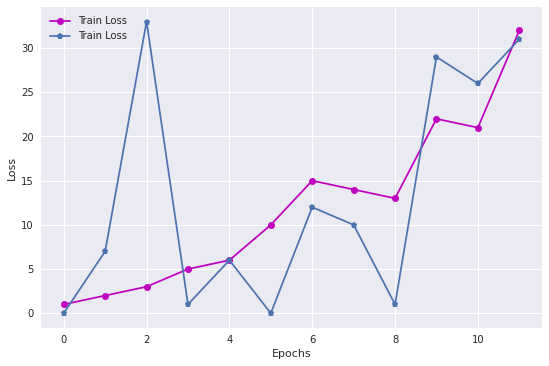

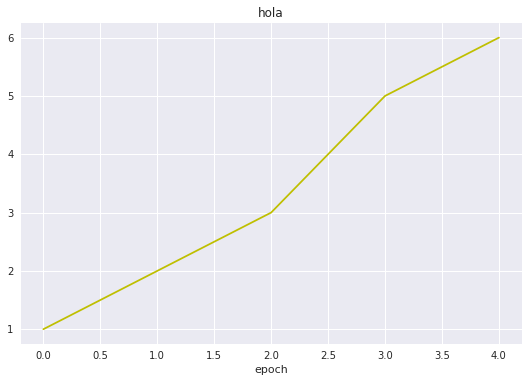

In [6]:
import matplotlib.pyplot as plt
import csv 

plt.style.use(['seaborn'])

data = [1,2,3,5,6,10,15,14,13,22,21,32]
data3 = [0,7,33,1,6,0,12,10,1,29,26,31]
data1 = [1,2,3,5,6,]


plt.figure(1)
plt.plot(data,"m-o", label="Train Loss")
plt.plot(data3,"-p" ,label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("hola.png")
plt.legend()



plt.figure(2)
plt.plot(data1,"y-")

plt.title("hola")
plt.xlabel("epoch")

plt.savefig("nnnn.png")

with open("sape.csv", "w") as f:
    write = csv.writer(f)
    write.writerow(data)
    write.writerow(data3)